2025-04-28 13:39:30.179486: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745847570.371928      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745847570.433770      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered



Removing BACKGROUND...


I0000 00:00:1745847594.924588      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745847594.925314      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1745847616.635332      78 cuda_dnn.cc:529] Loaded cuDNN version 90300



Removing CONCLUSIONS...

Removing METHODS...

Removing OBJECTIVE...

Removing RESULTS...


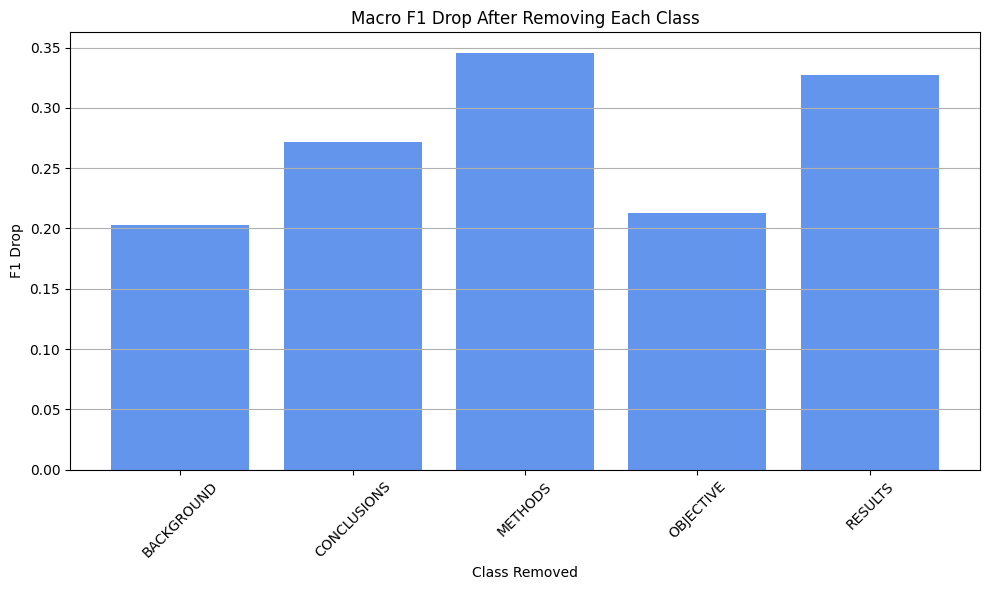

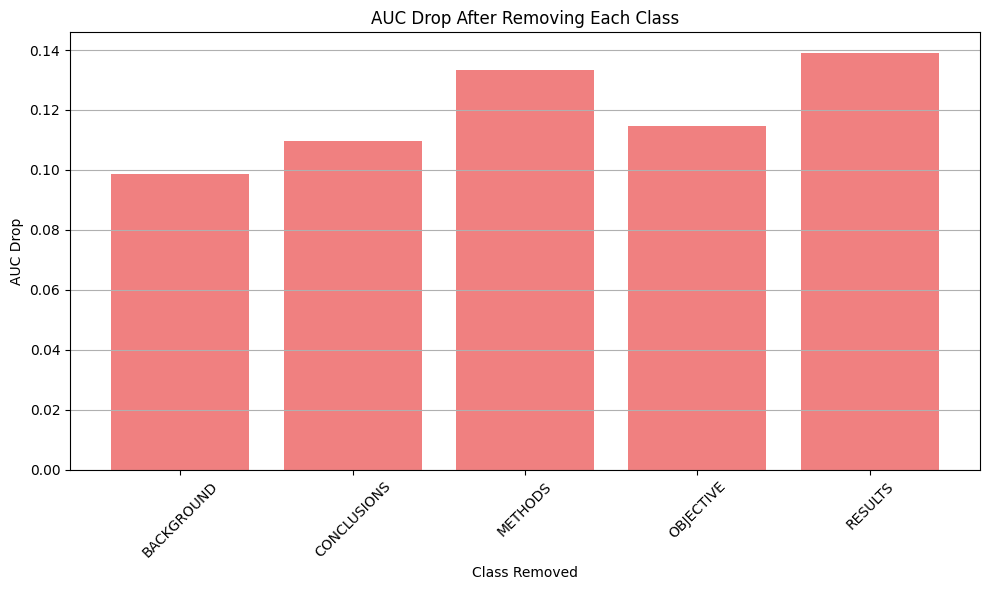

,Class Removed,F1 after removal,AUC after removal,F1 drop,AUC drop
0,BACKGROUND,0.628312,0.863413,0.202988,0.098687
1,CONCLUSIONS,0.559428,0.852569,0.271872,0.109531
2,METHODS,0.485913,0.828692,0.345387,0.133408
3,OBJECTIVE,0.618639,0.847419,0.212661,0.114681
4,RESULTS,0.504117,0.823141,0.327183,0.138959


In [1]:
# --- Step 0: Imports ---
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, roc_auc_score

# --- Step 1: Prepare data ---
def prepare_data(path):
    records = []
    with open(path, 'r', encoding='utf-8') as f:
        current_id = None
        count = 0
        for raw in f:
            line = raw.strip()
            if not line:
                continue
            if line.startswith('###'):
                current_id = line[3:]
                count = 1
            else:
                parts = line.split(None, 1)
                label = parts[0]
                text = parts[1] if len(parts) > 1 else ''
                records.append({
                    'id': current_id,
                    'order': count,
                    'label': label,
                    'text': text
                })
                count += 1
    return pd.DataFrame(records)

# Load dataset
train_path = '../input/200k-abstract-2/train.txt'  # Adjust if needed

df = prepare_data(train_path)

# Set label encoder manually to avoid mismatch
label_classes = ['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS']
label_encoder = LabelEncoder()
label_encoder.fit(label_classes)
df['label_enc'] = label_encoder.transform(df['label'])

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    df['text'].astype(str).to_numpy(),
    df['label_enc'].astype(np.int32),
    test_size=0.2, random_state=42, stratify=df['label_enc']
)

# --- Step 2: Constants ---
BASELINE_F1 = 0.8313
BASELINE_AUC = 0.9621
NUM_CLASSES = len(label_classes)

# --- Step 3: Model ---
def build_model():
    max_tokens = 50000
    seq_len = 128
    embedding_dim = 200

    text_vectorizer = tf.keras.layers.TextVectorization(
        max_tokens=max_tokens,
        output_mode='int',
        output_sequence_length=seq_len
    )
    text_vectorizer.adapt(X_train)

    inputs = tf.keras.Input(shape=(), dtype=tf.string)
    x = text_vectorizer(inputs)
    x = tf.keras.layers.Embedding(max_tokens, embedding_dim)(x)

    conv_blocks = []
    for kernel_size in [3, 4, 5]:
        conv = tf.keras.layers.Conv1D(64, kernel_size, activation='relu', padding='same')(x)
        conv = tf.keras.layers.MaxPooling1D()(conv)
        conv_blocks.append(conv)

    x = tf.keras.layers.Concatenate()(conv_blocks)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# --- Step 4: LOCO function ---
def loco_run(class_to_remove, results):
    print(f"\nRemoving {class_to_remove}...")
    
    # Remove class
    mask = y_train != label_encoder.transform([class_to_remove])[0]
    X_sub = X_train[mask]
    y_sub = y_train[mask]

    X_val_sub = X_val
    y_val_sub = y_val

    model = build_model()

    batch_size = 64
    train_ds = tf.data.Dataset.from_tensor_slices((X_sub, y_sub)).batch(batch_size)
    val_ds = tf.data.Dataset.from_tensor_slices((X_val_sub, y_val_sub)).batch(batch_size)

    model.fit(train_ds, validation_data=val_ds, epochs=20, verbose=0)

    y_val_probs = model.predict(X_val_sub, verbose=0)
    y_val_pred = np.argmax(y_val_probs, axis=1)

    try:
        y_val_bin = tf.keras.utils.to_categorical(y_val_sub, num_classes=NUM_CLASSES)
        auc = roc_auc_score(y_val_bin, y_val_probs, average='macro', multi_class='ovr')
    except ValueError:
        auc = np.nan

    f1 = f1_score(y_val_sub, y_val_pred, average='macro')

    results.append({
        'Class Removed': class_to_remove,
        'F1 after removal': f1,
        'AUC after removal': auc,
        'F1 drop': BASELINE_F1 - f1,
        'AUC drop': BASELINE_AUC - auc
    })

# --- Step 5: Run all classes ---
def loco_full():
    results = []
    for cls in label_encoder.classes_:
        loco_run(cls, results)
    loco_df = pd.DataFrame(results)
    loco_df.to_csv('/kaggle/working/loco_results.csv', index=False)

    # --- Step 6: Bar Plots ---
    plt.figure(figsize=(10,6))
    plt.bar(loco_df['Class Removed'], loco_df['F1 drop'], color='cornflowerblue')
    plt.title('Macro F1 Drop After Removing Each Class')
    plt.ylabel('F1 Drop')
    plt.xlabel('Class Removed')
    plt.grid(axis='y')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('/kaggle/working/loco_f1_drop.png')
    plt.show()

    plt.figure(figsize=(10,6))
    plt.bar(loco_df['Class Removed'], loco_df['AUC drop'], color='lightcoral')
    plt.title('AUC Drop After Removing Each Class')
    plt.ylabel('AUC Drop')
    plt.xlabel('Class Removed')
    plt.grid(axis='y')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('/kaggle/working/loco_auc_drop.png')
    plt.show()

    return loco_df

# --- Step 7: GO ---
loco_full()
